
# Weather Prediction With Machine Learning


### Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

### Process Data

In [ ]:
original = pd.read_csv('seattle-weather.csv')
original.head(5)

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


### Process Data and One Hot Encoding

In [ ]:
original.isna().sum() # Drop rows with missing values
data = original.drop('date', axis=1)

# One-hot encode the 'weather' column
weather_encoded = pd.get_dummies(data['weather'], prefix='weather')
data = pd.concat([data, weather_encoded], axis=1)

# Drop the original 'weather' column
data = data.drop('weather', axis=1)
print(data.head(5)) # this is how the dataset currently look like

# Scale numerical features to hopefully get better average result
scaler = StandardScaler()
numerical_features = ['precipitation', 'temp_max', 'temp_min', 'wind']
data[numerical_features] = scaler.fit_transform(data[numerical_features])

   precipitation  temp_max  temp_min  wind  weather_drizzle  weather_fog  \
0            0.0      12.8       5.0   4.7             True        False   
1           10.9      10.6       2.8   4.5            False        False   
2            0.8      11.7       7.2   2.3            False        False   
3           20.3      12.2       5.6   4.7            False        False   
4            1.3       8.9       2.8   6.1            False        False   

   weather_rain  weather_snow  weather_sun  
0         False         False        False  
1          True         False        False  
2          True         False        False  
3          True         False        False  
4          True         False        False  


### Split Into Test and Train Dataloaders

In [ ]:
# Split data
X = data.drop(list(weather_encoded.columns), axis=1) #Exclude weather
y = data[list(weather_encoded.columns)] #Predict all weather


# Create train and test loaders
def create_loaders(X_train, y_train, X_test, y_test, batch_size):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

  # Convert to tensors
  X_train = torch.tensor(X_train.values, dtype=torch.float32)
  y_train = torch.tensor(y_train.values, dtype=torch.float32)
  X_test = torch.tensor(X_test.values, dtype=torch.float32)
  y_test = torch.tensor(y_test.values, dtype=torch.float32)

  train_dataset = TensorDataset(X_train, y_train)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_dataset = TensorDataset(X_test, y_test)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class WeatherPredictor(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(WeatherPredictor, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x = x.unsqueeze(1)  # Add batch dimension, previously the shape only had two dimensions (around 1400 data, 4 features)
    out, _ = self.lstm(x)
    out = self.fc(out[:, -1, :])
    return out

### Initialize Neural Network Model and Optimizer

In [ ]:
def initialization(hidden_size, lr):
  input_size = X_train.shape[1]
  output_size = 5  # Number of weather categories
  model = WeatherPredictor(input_size, hidden_size, output_size)
  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)
  # optimizer = optim.LBFGS(model.parameters(), lr=0.001)
  return model, criterion, optimizer

### Training the Neural Network

In [ ]:
num_epochs = 80

def train_model(model, train_loader, test_loader, criterion, optimizer):
  test_accuracy_history = []
  train_accuracy_history = []

  for epoch in range(num_epochs):
      model.train()
      correct = 0
      total = 0
      for i, (inputs, target) in enumerate(train_loader):
          optimizer.zero_grad()
          output = model(inputs)
          loss = criterion(output, target)
          loss.backward()
          optimizer.step()

          # Calculate training accuracy
          _, predicted = torch.max(output.data, 1)
          total += target.size(0)
          correct += (predicted == torch.argmax(target, dim=1)).sum().item()

      train_accuracy = 100 * correct / total
      train_accuracy_history.append(train_accuracy)

      # Evaluate on test set
      model.eval()
      correct = 0
      total = 0
      with torch.no_grad():
          for inputs, target in test_loader:
              output = model(inputs)
              _, predicted = torch.max(output.data, 1)
              total += target.size(0)
              correct += (predicted == torch.argmax(target, dim=1)).sum().item()

      test_accuracy = 100 * correct / total
      test_accuracy_history.append(test_accuracy)

      # print(f'Epoch {epoch+1}/{num_epochs}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')
  return sum(test_accuracy_history[-10:])/10

  print("Finished Training")

### Parameters Tunning

In [ ]:
batch_size = 10
hidden_size = 10  # arbitrary, but 25 worked well than most, so the loop will try up until 30
learning_rate = 0.1
test_result = []

for b in range(5):
  hidden_size = 10
  for h in range(5):
    learning_rate = 0.1
    for l in range(3):
      train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
      test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)
      model, criterion, optimizer = initialization(hidden_size, learning_rate)
      test_result.append(train_model(model, train_loader, test_loader, criterion, optimizer))
      print(f'Batch Size: {batch_size}, Hidden Size: {hidden_size}, Learning Rate: {learning_rate}, Test Accuracy: {test_result[-1]}')
      learning_rate /= 10
    hidden_size += 5
  batch_size += 10
print(test_result)

Batch Size: 10, Hidden Size: 10, Learning Rate: 0.1, Test Accuracy: 82.04081632653062
Batch Size: 10, Hidden Size: 10, Learning Rate: 0.01, Test Accuracy: 82.44897959183673
Batch Size: 10, Hidden Size: 10, Learning Rate: 0.001, Test Accuracy: 80.81632653061224
Batch Size: 10, Hidden Size: 15, Learning Rate: 0.1, Test Accuracy: 82.17687074829931
Batch Size: 10, Hidden Size: 15, Learning Rate: 0.01, Test Accuracy: 82.72108843537414
Batch Size: 10, Hidden Size: 15, Learning Rate: 0.001, Test Accuracy: 81.42857142857142
Batch Size: 10, Hidden Size: 20, Learning Rate: 0.1, Test Accuracy: 81.76870748299321
Batch Size: 10, Hidden Size: 20, Learning Rate: 0.01, Test Accuracy: 82.58503401360545
Batch Size: 10, Hidden Size: 20, Learning Rate: 0.001, Test Accuracy: 81.70068027210883
Batch Size: 10, Hidden Size: 25, Learning Rate: 0.1, Test Accuracy: 81.63265306122449
Batch Size: 10, Hidden Size: 25, Learning Rate: 0.01, Test Accuracy: 81.70068027210884
Batch Size: 10, Hidden Size: 25, Learning Ra

In [58]:
# Define the parameter values
batch_sizes = [10] * 15 + [20] * 15 + [30] * 15 + [40] * 15 + [50] * 15  # Repeat each batch size 15 times
hidden_sizes = [10, 10, 10, 15, 15, 15, 20, 20, 20, 25, 25, 25, 30, 30, 30] * 5
learning_rates = [0.1, 0.01, 0.001] * 25

# Create a dictionary to store the data
data = {
    'batch_size': batch_sizes,
    'hidden_size': hidden_sizes,
    'learning_rate': learning_rates,
    'test_accuracy': test_result
}

# Create a Pandas DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('test_result.csv', index=False)

### Save the Model

In [ ]:
torch.save(model.state_dict(), 'weather_predictor.pth')
# may use for weather prediction

### Graph the Result

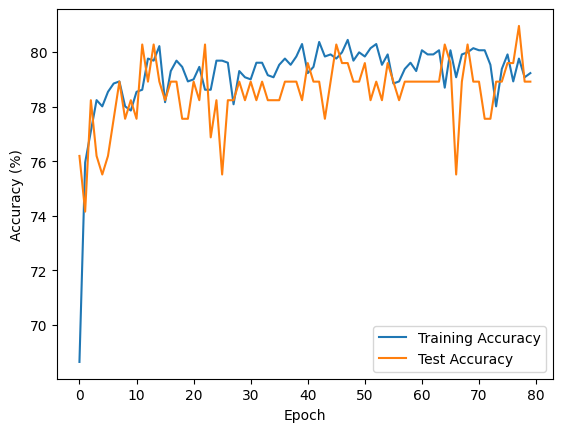

In [59]:
# note that here the graph only reflects the last iteration
plt.plot(train_accuracy_history, label='Training Accuracy')
plt.plot(test_accuracy_history, label = 'Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

### Predict Weather on One Day

In [ ]:
new_data = pd.DataFrame({
  'precipitation': [0.5],  # Example value
  'temp_max': [5],      # Example value
  'temp_min': [0],       # Example value
  'wind': [0]            # Example value
})

new_data[['precipitation', 'temp_max', 'temp_min', 'wind']] = scaler.transform(new_data[['precipitation', 'temp_max', 'temp_min', 'wind']])

prediction_data = torch.tensor(new_data.values, dtype=torch.float32)

output = model(prediction_data)
_, predicted = torch.max(output.data, 1)

weather_categories = list(weather_encoded.columns)
print(f'Predicted Weather: {weather_categories[predicted.item()][8:]}')

### if we found a suitable dataset that includes more recent weather, we might update result here

Predicted Weather: rain
